In [1]:
%load_ext autoreload
%autoreload 2

In [22]:
import numpy as np
import networkx as nx
from scipy.sparse import lil_matrix, csr_matrix, vstack
import copy
import os
import helper
from wl import *
from joblib import Parallel, delayed
from time import time
import matplotlib.pyplot as plt
from glob import glob
import math
import pandas as pd
import collections
import sklearn
from sklearn import linear_model
import psutil
import pickle
import functools
from matplotlib import cm
from IPython.display import display

In [3]:
GRAPH_DIR = 'data/graphs/ng-20-single'
ORIGINAL_DOCUMENTS_DIR = 'extract-concept-graphs/code/data/ng20__single/train'

In [4]:
def flatten(l, as_set = False):
    return functools.reduce(lambda acc, x: acc | set(x) if as_set else acc + list(x), l, set() if as_set else list())

## Retrieve graphs from Tobias' concept-graph extraction library

In [5]:
def get_graphs(directory, ext = 'gml', undirected = False, verbose = False):
    graphs = {}
    empty_graphs = []
    files = sorted(glob(directory + '/*' + ext))
    graph_ids = []
    for idx, graph_file in helper.log_progress(list(enumerate(files)), every = 100):
        topic_and_id = graph_file.split('/')[-1].replace('.gml', '')
        
        topic = topic_and_id.split('_')[0]
        if topic not in graphs:
            graphs[topic] = []
        with open(graph_file) as f:
            graph = f.read().split('\n')
        for idx, line in enumerate(graph):
            if line.startswith('label'):
                next_line = graph[idx + 1]
                label = next_line.replace('name', 'label')
                graph[idx] = label
        try:
            graph = nx.parse_gml(graph)
            if undirected:
                graph = graph.to_undirected()
            #graph = nx.read_gml(new_graph_file, label = 'label')
            if graph.number_of_nodes() > 0 and graph.number_of_edges() > 0:
                graphs[topic].append(graph)
                graph_ids.append(topic_and_id)
            else:
                empty_graphs.append(topic_and_id)
                if verbose: print("Found empty graph: {}".format(graph_file))
        except nx.NetworkXError as e:
            if verbose: print('Exception ({}): {}'.format(graph_file, e))
    if verbose: print('Found empty graphs: {}'.format(len(empty_graphs)))
    return graphs, empty_graphs, graph_ids

graphs_per_topic, empty_graphs, graph_ids = get_graphs(GRAPH_DIR, undirected = False, verbose = False)

Widget Javascript not detected.  It may not be installed or enabled properly.


## Retrieve original documents

In [6]:
def get_original_documents(DIR, ext = '/*/*.txt', whitelist = (), verbose = False):
    topics = collections.defaultdict(lambda: [])
    for file in helper.log_progress(list(sorted(glob(DIR + ext))), every = 100):
        topic_and_id = file.split('/')[-2]
        topic = topic_and_id.split('_')[0]
        if topic_and_id not in whitelist:
            if verbose: print('Ignoring: {} (not in whitelist)'.format(topic_and_id))
            continue
        with open(file) as f:
            topics[topic].append(f.read())
    return topics
docs_per_topic = get_original_documents(ORIGINAL_DOCUMENTS_DIR, whitelist = graph_ids)

Widget Javascript not detected.  It may not be installed or enabled properly.


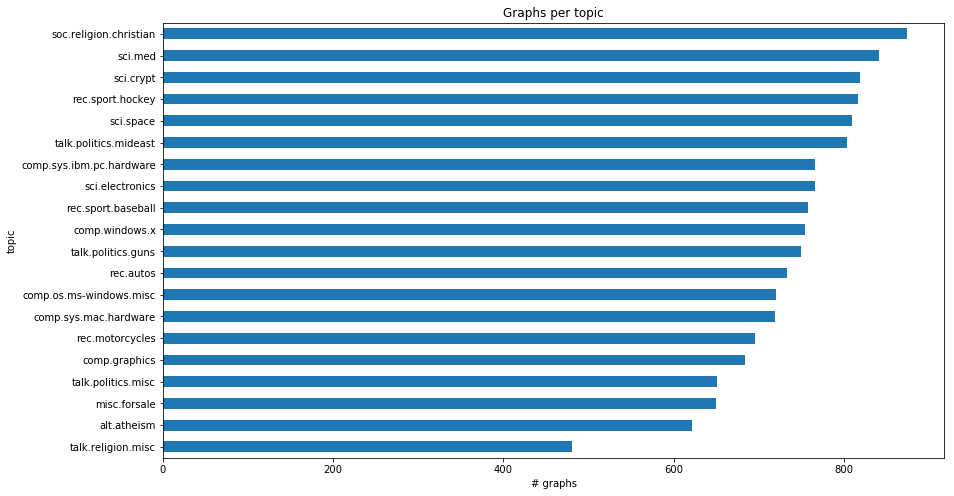

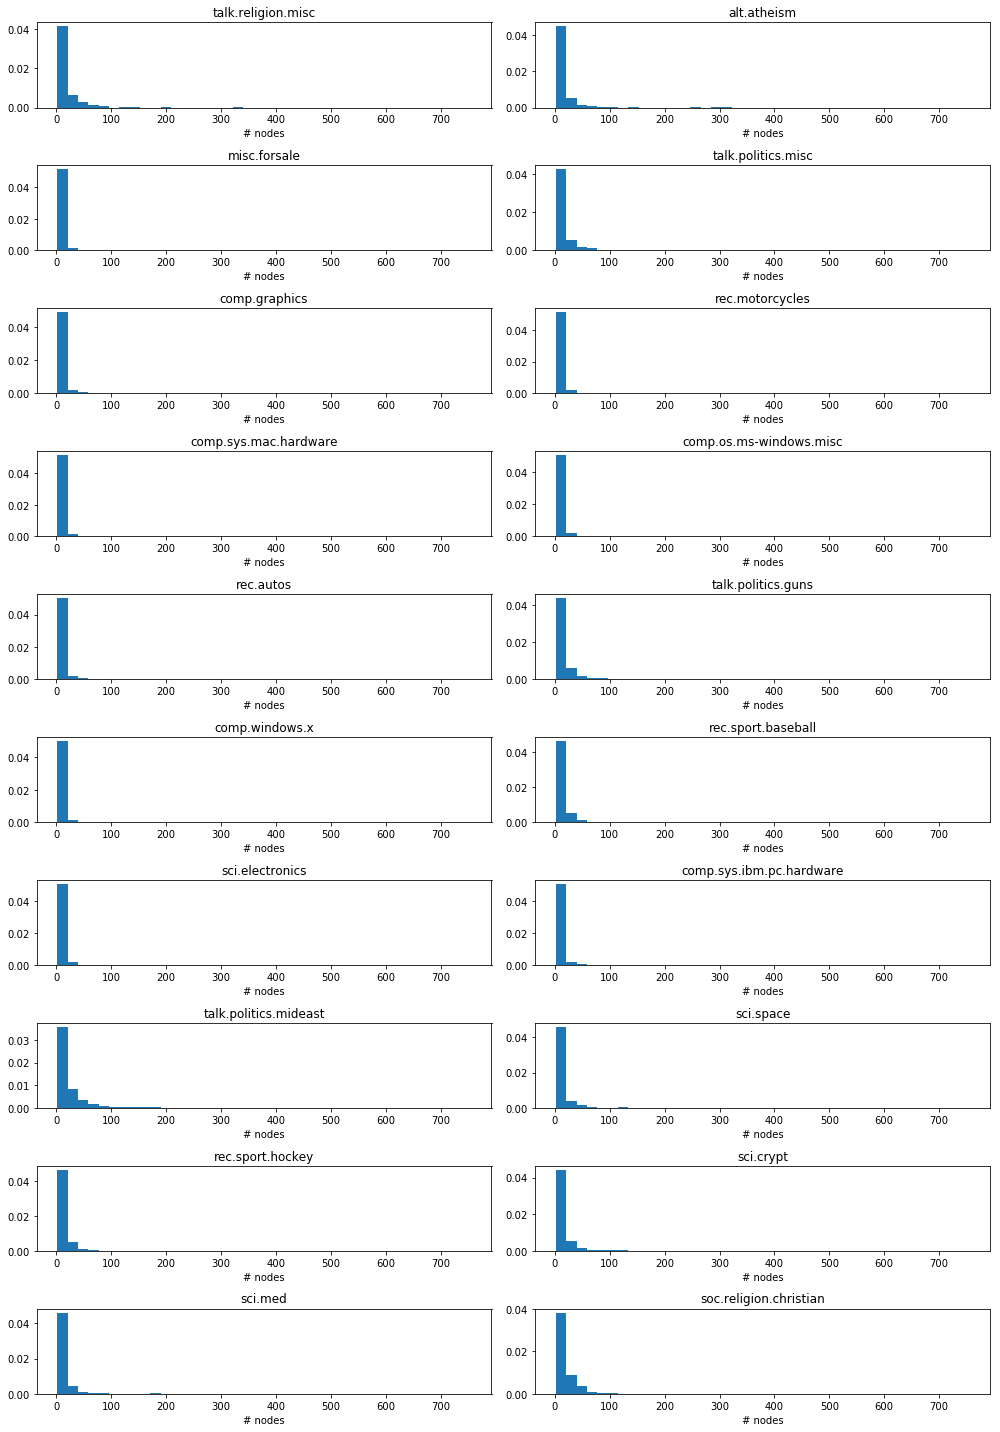

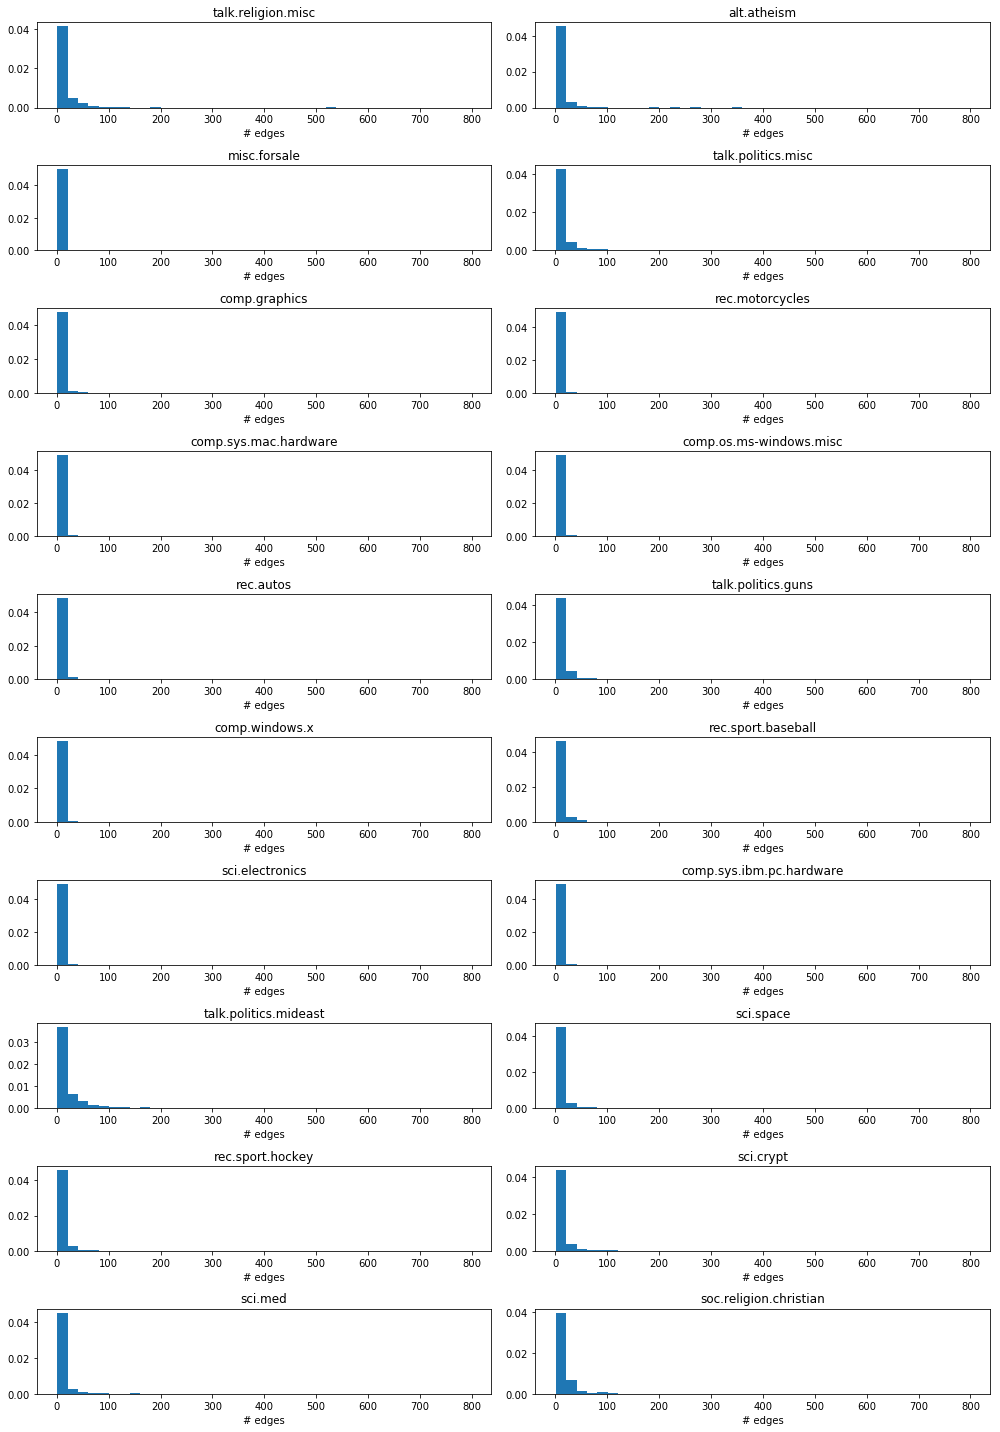

In [7]:
df_graphs_per_topic = pd.DataFrame([(topic, len(graphs), [len(x.nodes()) for x in graphs], [len(x.edges()) for x in graphs]) for topic, graphs in graphs_per_topic.items()], columns = ['topic', 'num_graphs', 'num_nodes', 'num_edges']).set_index(['topic']).sort_values(by = 'num_graphs')
ax = df_graphs_per_topic.plot.barh(title = 'Graphs per topic', legend = False, figsize = (14, 8))
ax.set_xlabel('# graphs')

def get_range_of(df, column):
    return df[column].apply(lambda x: min(x)).min(), df[column].apply(lambda x: max(x)).max()

nodes_range = get_range_of(df_graphs_per_topic, 'num_nodes')
edges_range = get_range_of(df_graphs_per_topic, 'num_edges')
plt.show()
ncols, nrows = (2, 10)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize = (14, 20))
fig_, axes_ = plt.subplots(ncols=ncols, nrows=nrows, figsize = (14, 20))
for idx, (topic, (num_graphs, num_nodes, num_edges)) in enumerate(df_graphs_per_topic.iterrows()):
    row = int(idx / ncols)
    col = idx % ncols
    ax = axes[row][col]
    ax_ = axes_[row][col]
    
    # 
    ax.set_title("{}".format(topic))
    ax.set_xlabel('# nodes')
    ax.hist(num_nodes, bins=40, normed = True, range = nodes_range)
    
    #
    ax_.set_title("{}".format(topic))
    ax_.set_xlabel('# edges')
    ax_.hist(num_edges, bins=40, normed = True, range = edges_range)
fig.tight_layout()
fig_.tight_layout()
plt.show()

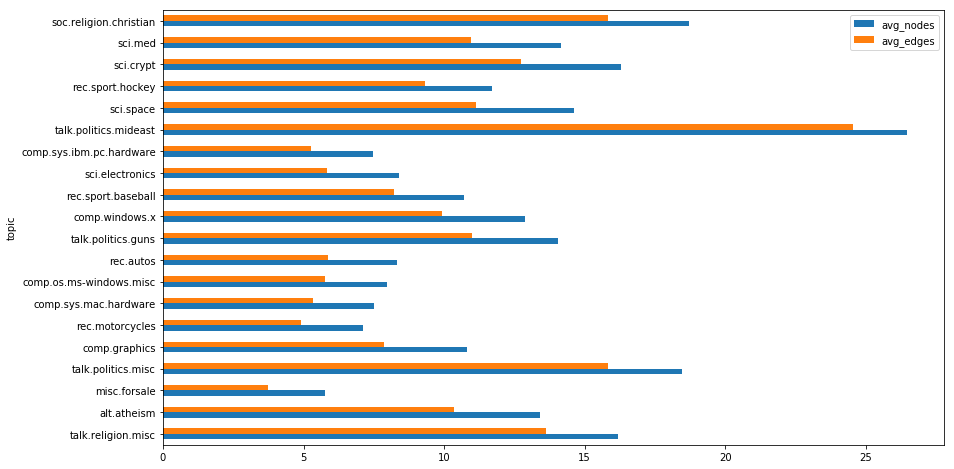

In [8]:
df_graphs_per_topic['avg_nodes'] = df_graphs_per_topic.num_nodes.apply(lambda x: np.mean(x))
df_graphs_per_topic['avg_edges'] = df_graphs_per_topic.num_edges.apply(lambda x: np.mean(x))
df_graphs_per_topic.plot(kind = 'barh', y = ['avg_nodes', 'avg_edges'], figsize = (14, 8))
plt.show()

## Filter categories

In [9]:
REMOVE_CATEGORIES = ['misc.forsale', 'comp.graphics']
REMOVE_CATEGORIES = []
graphs = graphs_per_topic.copy()
docs = docs_per_topic.copy()
if len(REMOVE_CATEGORIES):
    for cat in REMOVE_CATEGORIES:
        del graphs[cat]
        del docs[cat]

In [12]:
all_graphs = flatten(graphs.values())
all_docs = flatten(docs.values())

In [13]:
all_nodes = set()
for g in all_graphs:
    all_nodes |= set(g.nodes())

In [14]:
print('#docs:\t\t{}\n#graphs:\t{}'.format(len(all_docs), len(all_graphs)))
print('Unique tokens found: {}'.format(len(all_nodes)))
assert len(all_docs) == len(all_graphs)

#docs:		14710
#graphs:	14710
Unique tokens found: 125397


## Create train/test split

In [15]:
def get_train_test_split(topic_graphs, train_split_ratio = 0.8):
    train = []
    test = []
    num_elements = {}
    for topic, graphs in topic_graphs.items():
        num_elements_train = int(len(graphs) * train_split_ratio)
        train += [(topic, x) for x in graphs[:num_elements_train]]
        test += [(topic, x) for x in graphs[num_elements_train:]]
    return train, test

train, test = get_train_test_split(graphs)

In [16]:
print('#graphs\n\ttrain:\t{}\n\ttest:\t{}'.format(len(train), len(test)))

#graphs
	train:	11760
	test:	2950


In [17]:
H = 2

## Calculate phi and gram-matrix of WL kernel for training instances

In [18]:
adjs = []
nodes = []
for topic, graph in train:
    sorted_nodes = sorted(graph.nodes())
    adjs.append(nx.adjacency_matrix(graph, nodelist = sorted_nodes))
    nodes.append(sorted_nodes)
    
print('Calculating WL_train: start', psutil.virtual_memory())
K_train, phi_list_train, label_lookup_train, label_counters_train = WL_compute(adjs, nodes, H, all_nodes = all_nodes, DEBUG = True, compute_k = False)
print('Calculating WL_train: end', psutil.virtual_memory())

Calculating WL_train: start svmem(total=8589934592, available=4185477120, percent=51.3, used=4290064384, free=2693677056, active=1176907776, inactive=1491800064, wired=1621356544)
Number of original labels 125441
K original is computed
Iteration 0: phi is computed
	Graph          0/11760
	Graph       1000/11760
	Graph       2000/11760
	Graph       3000/11760
	Graph       4000/11760
	Graph       5000/11760
	Graph       6000/11760
	Graph       7000/11760
	Graph       8000/11760
	Graph       9000/11760
	Graph      10000/11760
	Graph      11000/11760
Number of compressed labels 127200
Itaration 0: phi computed
Iteration 1: phi is computed
	Graph          0/11760
	Graph       1000/11760
	Graph       2000/11760
	Graph       3000/11760
	Graph       4000/11760
	Graph       5000/11760
	Graph       6000/11760
	Graph       7000/11760
	Graph       8000/11760
	Graph       9000/11760
	Graph      10000/11760
	Graph      11000/11760
Number of compressed labels 127499
Itaration 1: phi computed
Calculat

## Train classifier with the phi s of the training instances

In [24]:
clf = sklearn.linear_model.Perceptron(n_iter = 500, verbose = False, n_jobs = -1)
X = phi_list_train[-1].T
Y = [topic for topic, graphs in train]
clf.fit(X, Y)

Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      n_iter=500, n_jobs=-1, penalty=None, random_state=0, shuffle=True,
      verbose=False, warm_start=False)

## Get predictions for test instances

### Calculate test phi s

In [25]:
%%time
def get_prediction(topic, graph):
    return compute_phi(graph, phi_list_train[0].shape, label_lookup_train, label_counters_train, h = H)[-1]

USED_SET = test
PARALLEL_PREDICTION_JOBS = 0
t = time()

if PARALLEL_PREDICTION_JOBS > 1:
    phi_test = Parallel(n_jobs=PARALLEL_PREDICTION_JOBS)(delayed(get_prediction)(*d) for d in list(USED_SET))
else:
    phi_test = [get_prediction(*d) for d in USED_SET]

CPU times: user 37.4 s, sys: 395 ms, total: 37.8 s
Wall time: 37.9 s


In [27]:
nodes_nums = sum([nx.number_of_nodes(graph) for topic, graph in train])
nodes_nums

148215

### Predict test instances

In [28]:
%%time
def calculate_batches(l, fn, num_batches = 10, print_every = 5):
    elements = []
    num_elements_per_batch = math.ceil(len(l) / num_batches)
    print('Starting: #elements: {}, #batches: {}, #elements per Batch: {}'.format(len(l), num_batches, num_elements_per_batch))
    for idx in range(num_batches):
        start = idx * num_elements_per_batch
        end = min(len(l), start + num_elements_per_batch)
        if idx % print_every == 0: print('\tIteration: {:>4}/{}'.format(idx, num_batches))
        if end - start <= 0:
            break
        elements += fn(l[start:end]).tolist()
    return elements
predicted = calculate_batches(phi_test, clf.predict)

Starting: #elements: 2950, #batches: 10, #elements per Batch: 295
	Iteration:    0/10
	Iteration:    5/10
CPU times: user 4.09 s, sys: 3.2 s, total: 7.29 s
Wall time: 5.66 s


### Metrics

In [29]:
Y_real = [topic for topic,graph in USED_SET]
Y_pred = predicted

#### About sparsity of test phi

In [30]:
df_phi_test_non_zero_elements = pd.DataFrame(list(zip(Y_real, Y_pred, [np.count_nonzero(x) for x in phi_test])), columns = ['real_topic', 'pred_topic', 'num_phi_non_zero'])

In [31]:
display(df_phi_test_non_zero_elements.groupby(by = 'real_topic').describe())
display(df_phi_test_non_zero_elements.groupby(by = 'pred_topic').describe())

num_phi_non_zero                                  \
                                    count       mean        std  min  25%   
real_topic                                                                  
alt.atheism                         125.0   9.456000  20.791788  1.0  2.0   
comp.graphics                       137.0   6.489051  26.581207  1.0  2.0   
comp.os.ms-windows.misc             144.0   4.277778   3.644028  1.0  2.0   
comp.sys.ibm.pc.hardware            154.0   4.584416   5.632192  1.0  2.0   
comp.sys.mac.hardware               144.0   4.354167   3.680356  1.0  2.0   
comp.windows.x                      151.0   8.609272  33.683621  1.0  2.0   
misc.forsale                        130.0   4.384615   4.254290  1.0  2.0   
rec.autos                           147.0   5.469388   5.948761  1.0  2.0   
rec.motorcycles                     139.0   6.093525  14.299028  1.0  2.0   
rec.sport.baseball                  152.0   6.157895   5.737186  1.0  2.0   
rec.sport.hockey                    164.0   8.000000   8.640751  1.0  3.0   
sci.crypt                           164.0  12.573171  33.266365  1.0  3.0   
sci.electronics                     154.0   7.376623  28.645473  1.0  2.0   
sci.med                             169.0   8.923077  20.048453  1.0  2.0   
sci.space                           162.0   7.987654  10.304065  1.0  2.0   
soc.religion.christian              175.0  11.828571  16.318817  1.0  4.0   
talk.politics.guns                  150.0   9.526667  12.371594  1.0  3.0   
talk.politics.mideast               161.0  15.919255  28.404440  1.0  3.0   
talk.politics.misc                  131.0  12.709924  30.034464  1.0  3.0   
talk.religion.misc                   97.0   8.195876   9.942165  1.0  2.0   

                                             
                          50%    75%    max  
real_topic                                   
alt.atheism               4.0   9.00  192.0  
comp.graphics             3.0   6.00  312.0  
comp.os.ms-windows.misc   3.5   5.00   22.0  
comp.sys.ibm.pc.hardware  3.0   5.00   58.0  
comp.sys.mac.hardware     3.0   6.00   25.0  
comp.windows.x            3.0   6.00  351.0  
misc.forsale              3.0   6.00   20.0  
rec.autos                 4.0   7.00   49.0  
rec.motorcycles           3.0   6.00  165.0  
rec.sport.baseball        4.0   8.25   38.0  
rec.sport.hockey          5.0  10.00   81.0  
sci.crypt                 6.0  10.00  373.0  
sci.electronics           4.0   6.00  356.0  
sci.med                   4.0   8.00  166.0  
sci.space                 4.5   9.00   62.0  
soc.religion.christian    7.0  12.50  114.0  
talk.politics.guns        5.0  11.00   99.0  
talk.politics.mideast     7.0  15.00  239.0  
talk.politics.misc        5.0  11.00  240.0  
talk.religion.misc        4.0   9.00   50.0

num_phi_non_zero                                  \
                                    count       mean        std  min  25%   
pred_topic                                                                  
alt.atheism                          56.0  10.732143  15.096648  2.0  4.0   
comp.graphics                        36.0  18.000000  51.307476  2.0  4.0   
comp.os.ms-windows.misc              78.0   9.012821  18.808325  2.0  3.0   
comp.sys.ibm.pc.hardware             75.0  10.253333  14.363141  2.0  4.0   
comp.sys.mac.hardware                54.0   9.055556  13.240043  2.0  3.0   
comp.windows.x                       81.0  16.172840  45.399281  2.0  3.0   
misc.forsale                       1415.0   3.612014   9.871594  1.0  1.0   
rec.autos                            37.0   9.675676   8.647588  2.0  4.0   
rec.motorcycles                     168.0   7.934524   7.062713  2.0  4.0   
rec.sport.baseball                   69.0  10.550725   8.640766  2.0  4.0   
rec.sport.hockey                    143.0   9.363636   9.597201  2.0  4.0   
sci.crypt                            84.0  21.916667  45.502074  2.0  5.0   
sci.electronics                      82.0   7.219512   5.011159  2.0  4.0   
sci.med                              75.0   9.880000  15.614408  2.0  3.0   
sci.space                            69.0   9.434783   9.867472  2.0  4.0   
soc.religion.christian              130.0  14.284615  22.829409  2.0  4.0   
talk.politics.guns                   68.0  10.676471   9.826011  2.0  4.0   
talk.politics.mideast               111.0  20.855856  34.874801  2.0  6.0   
talk.politics.misc                   82.0  19.829268  39.720569  2.0  4.0   
talk.religion.misc                   37.0  15.486486  18.349420  2.0  4.0   

                                              
                           50%    75%    max  
pred_topic                                    
alt.atheism                6.5  13.00  109.0  
comp.graphics              8.0  10.25  312.0  
comp.os.ms-windows.misc    5.0   9.00  166.0  
comp.sys.ibm.pc.hardware   6.0  10.00   93.0  
comp.sys.mac.hardware      5.5   9.00   80.0  
comp.windows.x             6.0  11.00  351.0  
misc.forsale               2.0   4.00  356.0  
rec.autos                  7.0  12.00   43.0  
rec.motorcycles            6.0  10.00   70.0  
rec.sport.baseball         7.0  15.00   38.0  
rec.sport.hockey           6.0  11.00   81.0  
sci.crypt                  9.0  20.00  373.0  
sci.electronics            6.0   9.00   31.0  
sci.med                    6.0   9.50   94.0  
sci.space                  6.0  10.00   62.0  
soc.religion.christian     8.0  15.00  192.0  
talk.politics.guns         7.5  13.25   43.0  
talk.politics.mideast     10.0  19.00  239.0  
talk.politics.misc         9.0  14.75  240.0  
talk.religion.misc         7.0  16.00   66.0

In [32]:
max_ = 0
vals_over_1 = 0
for i in phi_test:
    vals = i[i > 1]
    if not len(vals): continue
    vals_over_1 += 1
    m = max(vals)
    if m > max_:
        max_ = m
        print(max_)
print(vals_over_1)

2
3
4
5
6
7
2677


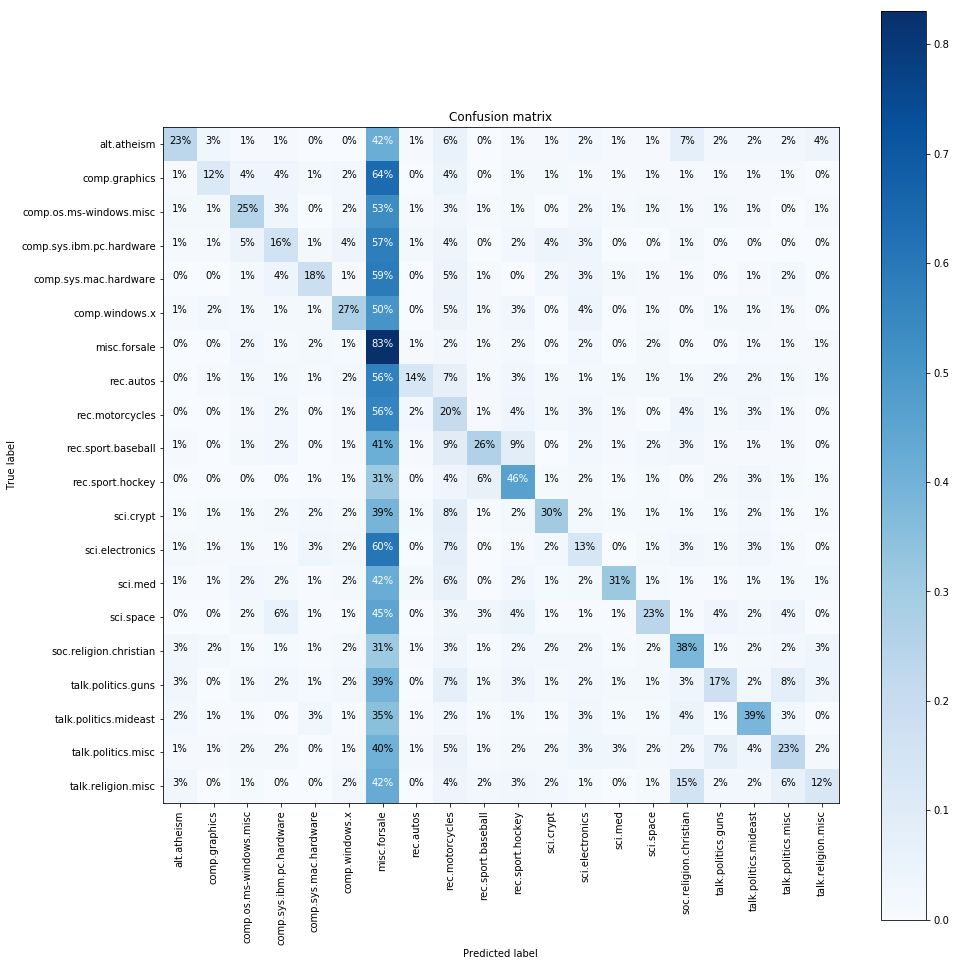

In [33]:
cf_mat = sklearn.metrics.confusion_matrix(Y_real, Y_pred)
fig = plt.figure(figsize=(14, 14))
helper.plot_confusion_matrix(cf_mat, clf.classes_, normalize = True)
plt.show()

In [34]:
with open('data/graphs.npy', 'wb') as f:
    pickle.dump({
            'train': train,
            'test': test,
            'K_train': K_train,
            'phi_list_train': phi_list_train,
            'label_lookup_train': label_lookup_train,
            'label_counters_train': label_counters_train
    }, f)